In [1]:
import torch
import esm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [2]:
device

device(type='cpu')

In [3]:
# Load ESM-2 model
# model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model, alphabet = esm.pretrained.esm2_t36_3B_UR50D()
batch_converter = alphabet.get_batch_converter()
model = model.eval() #.cuda()  # disables dropout for deterministic results


In [5]:
dir(alphabet)
alphabet.all_toks

['<cls>',
 '<pad>',
 '<eos>',
 '<unk>',
 'L',
 'A',
 'G',
 'V',
 'S',
 'E',
 'R',
 'T',
 'I',
 'D',
 'P',
 'K',
 'Q',
 'N',
 'F',
 'Y',
 'M',
 'H',
 'W',
 'C',
 'X',
 'B',
 'U',
 'Z',
 'O',
 '.',
 '-',
 '<null_1>',
 '<mask>']

In [6]:
model

ESM2(
  (embed_tokens): Embedding(33, 2560, padding_idx=1)
  (layers): ModuleList(
    (0-35): 36 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
        (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
        (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
        (out_proj): Linear(in_features=2560, out_features=2560, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=2560, out_features=10240, bias=True)
      (fc2): Linear(in_features=10240, out_features=2560, bias=True)
      (final_layer_norm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=1440, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((2560,), ep

In [7]:
torch.cuda.empty_cache()

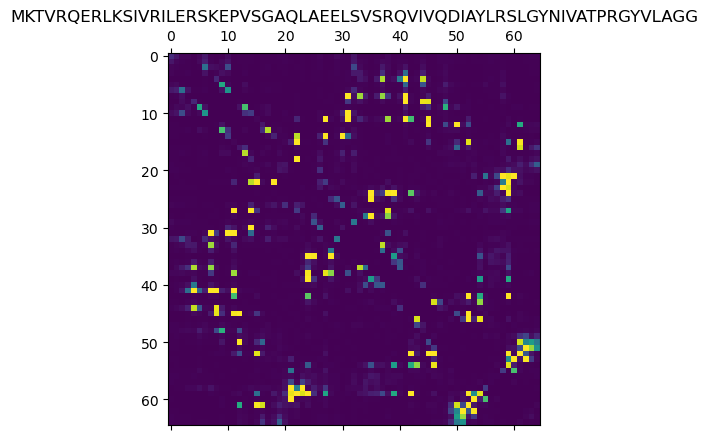

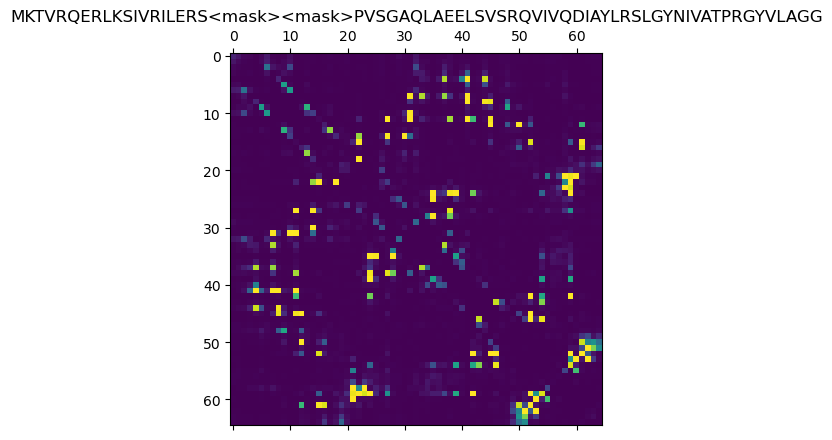

In [8]:

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein1", "MKTVRQERLKSIVRILERS<mask><mask>PVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    #("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    #("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    # ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens.to(device), repr_layers=[36], return_contacts=True)
token_representations = results["representations"][36]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"].cpu()):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()

In [9]:
batch_lens

tensor([67, 67])

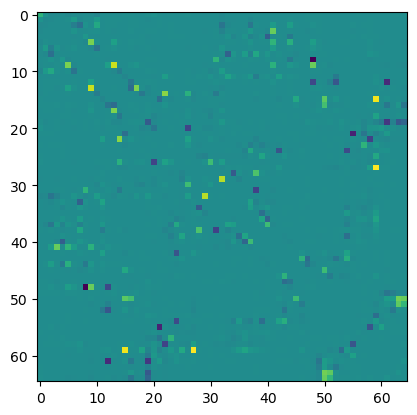

In [10]:
plt.imshow(results["contacts"][0].cpu() - results["contacts"][1].cpu())


In [11]:
results.keys()

dict_keys(['logits', 'representations', 'attentions', 'contacts'])

In [12]:
results['attentions'][0].shape

torch.Size([36, 40, 67, 67])

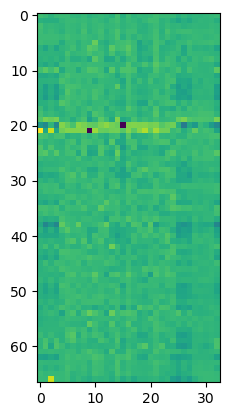

In [13]:
plt.imshow(results['logits'][1].cpu()-results['logits'][0].cpu())

In [14]:
# fastpred = tokenizer.decode(torch.tensor(cpulogits[:,:-1,:].numpy().argmax(-1)[0]), skip_special_tokens=False).replace("<"," <").replace(">","> ")

list(zip([alphabet.get_tok(t) for t in results['logits'][0].cpu().numpy().argmax(-1)],[alphabet.get_tok(t) for t in results['logits'][1].cpu().numpy().argmax(-1)]))

[('<cls>', '<cls>'),
 ('M', 'M'),
 ('K', 'K'),
 ('T', 'T'),
 ('V', 'V'),
 ('R', 'R'),
 ('Q', 'Q'),
 ('E', 'E'),
 ('R', 'R'),
 ('L', 'L'),
 ('K', 'K'),
 ('S', 'S'),
 ('I', 'I'),
 ('V', 'V'),
 ('R', 'R'),
 ('I', 'I'),
 ('L', 'L'),
 ('E', 'E'),
 ('R', 'R'),
 ('S', 'S'),
 ('K', 'R'),
 ('E', 'E'),
 ('P', 'P'),
 ('V', 'V'),
 ('S', 'S'),
 ('G', 'G'),
 ('A', 'A'),
 ('Q', 'Q'),
 ('L', 'L'),
 ('A', 'A'),
 ('E', 'E'),
 ('E', 'E'),
 ('L', 'L'),
 ('S', 'S'),
 ('V', 'V'),
 ('S', 'S'),
 ('R', 'R'),
 ('Q', 'Q'),
 ('V', 'V'),
 ('I', 'I'),
 ('V', 'V'),
 ('Q', 'Q'),
 ('D', 'D'),
 ('I', 'I'),
 ('A', 'A'),
 ('Y', 'Y'),
 ('L', 'L'),
 ('R', 'R'),
 ('S', 'S'),
 ('L', 'L'),
 ('G', 'G'),
 ('Y', 'Y'),
 ('N', 'N'),
 ('I', 'I'),
 ('V', 'V'),
 ('A', 'A'),
 ('T', 'T'),
 ('P', 'P'),
 ('R', 'R'),
 ('G', 'G'),
 ('Y', 'Y'),
 ('V', 'V'),
 ('L', 'L'),
 ('A', 'A'),
 ('G', 'G'),
 ('G', 'G'),
 ('<eos>', '<eos>')]

In [15]:
" ".join([alphabet.get_tok(t) for t in results['logits'][0].cpu().numpy().argmax(-1)][1:-1])

'M K T V R Q E R L K S I V R I L E R S K E P V S G A Q L A E E L S V S R Q V I V Q D I A Y L R S L G Y N I V A T P R G Y V L A G G'

In [17]:
batch_tokens[0]

tensor([ 0, 20, 15, 11,  7, 10, 16,  9, 10,  4, 15,  8, 12,  7, 10, 12,  4,  9,
        10,  8, 15,  9, 14,  7,  8,  6,  5, 16,  4,  5,  9,  9,  4,  8,  7,  8,
        10, 16,  7, 12,  7, 16, 13, 12,  5, 19,  4, 10,  8,  4,  6, 19, 17, 12,
         7,  5, 11, 14, 10,  6, 19,  7,  4,  5,  6,  6,  2])

In [34]:
### Loss including <cls> and <eos> = 0.1479
loss = torch.nn.CrossEntropyLoss()
loss(results['logits'][0].cpu(), batch_tokens[0])

tensor(0.1479)

In [39]:
### Loss without <cls> and <eos> = 0.1525
print([alphabet.get_tok(t) for t in results['logits'][0].cpu().numpy().argmax(-1)])

loss(results['logits'][0][1:-1,],batch_tokens[0][1:-1])


['<cls>', 'M', 'K', 'T', 'V', 'R', 'Q', 'E', 'R', 'L', 'K', 'S', 'I', 'V', 'R', 'I', 'L', 'E', 'R', 'S', 'K', 'E', 'P', 'V', 'S', 'G', 'A', 'Q', 'L', 'A', 'E', 'E', 'L', 'S', 'V', 'S', 'R', 'Q', 'V', 'I', 'V', 'Q', 'D', 'I', 'A', 'Y', 'L', 'R', 'S', 'L', 'G', 'Y', 'N', 'I', 'V', 'A', 'T', 'P', 'R', 'G', 'Y', 'V', 'L', 'A', 'G', 'G', '<eos>']


tensor(0.1525)

In [40]:
# another example with and without <cls> and <eos>
print(loss(results['logits'][1].cpu()[1:-1,:], batch_tokens[1][1:-1]))
print(loss(results['logits'][1].cpu(), batch_tokens[1]))

tensor(0.8430)
tensor(0.8179)


In [22]:

def sequence_masker(seq, i, j):
    masked_sequence_list = seq.split()
    if j<=i:
        print(f"index j={j} must be greater than i={i}")
        raise
    for x in range(i, j):
        if j > len(seq):
            break
        masked_sequence_list[x] = f"<mask>"
    return " ".join(masked_sequence_list)

import re 
target_seq = data[0][1]
input_seq  = [" ".join(list(re.sub(r"[UZOB]", "X", target_seq)))]

batch_converter = alphabet.get_batch_converter()

masked_seq = sequence_masker(input_seq[0], 20, 21)
print(masked_seq)
batch_labels, batch_strs, batch_tokens = batch_converter([("prot1", masked_seq)])
print(batch_tokens)


batch_labels, batch_strs, batch_tokens = batch_converter([("prot1", " ".join(input_seq))])
print(batch_tokens)

M K T V R Q E R L K S I V R I L E R S K <mask> P V S G A Q L A E E L S V S R Q V I V Q D I A Y L R S L G Y N I V A T P R G Y V L A G G
tensor([[ 0, 20, 15, 11,  7, 10, 16,  9, 10,  4, 15,  8, 12,  7, 10, 12,  4,  9,
         10,  8, 15, 32, 14,  7,  8,  6,  5, 16,  4,  5,  9,  9,  4,  8,  7,  8,
         10, 16,  7, 12,  7, 16, 13, 12,  5, 19,  4, 10,  8,  4,  6, 19, 17, 12,
          7,  5, 11, 14, 10,  6, 19,  7,  4,  5,  6,  6,  2]])
tensor([[ 0, 20, 15, 11,  7, 10, 16,  9, 10,  4, 15,  8, 12,  7, 10, 12,  4,  9,
         10,  8, 15,  9, 14,  7,  8,  6,  5, 16,  4,  5,  9,  9,  4,  8,  7,  8,
         10, 16,  7, 12,  7, 16, 13, 12,  5, 19,  4, 10,  8,  4,  6, 19, 17, 12,
          7,  5, 11, 14, 10,  6, 19,  7,  4,  5,  6,  6,  2]])


In [23]:
input_seq[0]

'M K T V R Q E R L K S I V R I L E R S K E P V S G A Q L A E E L S V S R Q V I V Q D I A Y L R S L G Y N I V A T P R G Y V L A G G'

In [24]:
import re 
target_seq = data[0][1]
input_seq  = [" ".join(list(re.sub(r"[UZOB]", "X", target_seq)))]
print(input_seq)

['M K T V R Q E R L K S I V R I L E R S K E P V S G A Q L A E E L S V S R Q V I V Q D I A Y L R S L G Y N I V A T P R G Y V L A G G']


In [25]:
# same as tokenizer, but omit <bos> and <eos> tokens
alphabet.encode(input_seq[0])

[20,
 15,
 11,
 7,
 10,
 16,
 9,
 10,
 4,
 15,
 8,
 12,
 7,
 10,
 12,
 4,
 9,
 10,
 8,
 15,
 9,
 14,
 7,
 8,
 6,
 5,
 16,
 4,
 5,
 9,
 9,
 4,
 8,
 7,
 8,
 10,
 16,
 7,
 12,
 7,
 16,
 13,
 12,
 5,
 19,
 4,
 10,
 8,
 4,
 6,
 19,
 17,
 12,
 7,
 5,
 11,
 14,
 10,
 6,
 19,
 7,
 4,
 5,
 6,
 6]

In [26]:
batch_labels, batch_strs, batch_tokens

(['prot1'],
 ['M K T V R Q E R L K S I V R I L E R S K E P V S G A Q L A E E L S V S R Q V I V Q D I A Y L R S L G Y N I V A T P R G Y V L A G G'],
 tensor([[ 0, 20, 15, 11,  7, 10, 16,  9, 10,  4, 15,  8, 12,  7, 10, 12,  4,  9,
          10,  8, 15,  9, 14,  7,  8,  6,  5, 16,  4,  5,  9,  9,  4,  8,  7,  8,
          10, 16,  7, 12,  7, 16, 13, 12,  5, 19,  4, 10,  8,  4,  6, 19, 17, 12,
           7,  5, 11, 14, 10,  6, 19,  7,  4,  5,  6,  6,  2]]))